In [2]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt
import decoupler as dc

## Load adatas

In [2]:
adata_epi_chen      = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')
adata_epi_joanito   = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

In [3]:
adata_epi_chen_tme      = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.TME.h5ad')
adata_epi_joanito_tme   = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.TME.h5ad')

In [4]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)

dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_epi_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_epi_chen.obs['PatientID'] ]

chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_P18 = ['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

chen_patient_order_by_MSI_intensity_AC  = ['P26', 'P20', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_TC  = ['P19', 'P22', 'P23',]
chen_patient_order_by_MSI_intensity_SC  = ['P18', 'P17', 'P15']

joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'SC035', 'CRC2783', 'SC044']

dict_PatientID_to_MSI_class = {'CRC2783': 'MSI-I',
 'CRC2817': 'MSI-L',
 'SC035': 'MSI-I',
 'SC044': 'MSI-H',
 'P04': 'MSI-H',
 'P15': 'MSI-I',
 'P17': 'MSI-L',
 'P18': 'MSI-L',
 'P19': 'MSI-I',
 'P20': 'MSI-I',
 'P21': 'MSI-H',
 'P22': 'MSI-I',
 'P23': 'MSI-H',
 'P26': 'MSI-I'}

In [18]:
adata_epi_joanito   = adata_epi_joanito.raw.to_adata()
adata_epi_chen      = adata_epi_chen.raw.to_adata()

In [19]:
adata_epi_chen_tumor = adata_epi_chen[(adata_epi_chen.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity)) & 
                                      (adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_epi_joanito_tumor = adata_epi_joanito[(adata_epi_joanito.obs['PatientID'].isin(joanito_patient_order_by_MSI_intensity)) & 
                                            (adata_epi_joanito.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()

In [43]:
adata_epi_chen_tumor.obs['MSI_class']       = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_chen_tumor.obs['PatientID'] ]
adata_epi_joanito_tumor.obs['MSI_class']    = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_joanito_tumor.obs['PatientID'] ]

In [23]:
adata_epi_chen_tumor.raw = adata_epi_chen_tumor
# sc.pp.normalize_total(adata_epi_chen_tumor)
# sc.pp.log1p(adata_epi_chen_tumor)

adata_epi_chen_tumor.raw = adata_epi_chen_tumor
# sc.pp.normalize_total(adata_epi_joanito_tumor)
# sc.pp.log1p(adata_epi_joanito_tumor)

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_epi_joanito_tumor.var["mt"] = adata_epi_joanito_tumor.var_names.str.startswith("MT-")
# ribosomal genes
adata_epi_joanito_tumor.var["ribo"] = adata_epi_joanito_tumor.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_epi_joanito_tumor.var["hb"] = adata_epi_joanito_tumor.var_names.str.contains("^HB[^(P)]")

adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.mt==False].copy()
adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.ribo==False].copy()
adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.hb==False].copy()

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_epi_chen_tumor.var["mt"] = adata_epi_chen_tumor.var_names.str.startswith("MT-")
# ribosomal genes
adata_epi_chen_tumor.var["ribo"] = adata_epi_chen_tumor.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_epi_chen_tumor.var["hb"] = adata_epi_chen_tumor.var_names.str.contains("^HB[^(P)]")

adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.mt==False].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.ribo==False].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.hb==False].copy()

In [24]:
adata_epi_joanito_tumor.raw = adata_epi_joanito_tumor

sc.pp.normalize_total(adata_epi_joanito_tumor)
sc.pp.log1p(adata_epi_joanito_tumor)

adata_epi_chen_tumor.raw = adata_epi_chen_tumor

sc.pp.normalize_total(adata_epi_chen_tumor)
sc.pp.log1p(adata_epi_chen_tumor)

## Load DEGs

In [3]:
Joanito_scanpy_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')
# Joanito_scanpy_DEGs = Joanito_scanpy_DEGs[(Joanito_scanpy_DEGs['MSI_class']=='MSI_H') & (Joanito_scanpy_DEGs['adjusted_pvalue']<=.05)]
Joanito_scanpy_DEGs = Joanito_scanpy_DEGs[(Joanito_scanpy_DEGs['MSI_class']=='MSI_H')]

Joanito_scanpy_DEGs.reset_index(inplace=True, drop=True)

Chen_scanpy_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')
Chen_scanpy_DEGs = Chen_scanpy_DEGs[(Chen_scanpy_DEGs['MSI_class']=='MSI_H')]

# Chen_scanpy_DEGs = Chen_scanpy_DEGs[(Chen_scanpy_DEGs['MSI_class']=='MSI_H') & (Chen_scanpy_DEGs['adjusted_pvalue']<=0.05)]
Chen_scanpy_DEGs.reset_index(inplace=True, drop=True)

In [49]:
Joanito_pyDESeq2_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')
Chen_pyDESeq2_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')

Chen_pyDESeq2_DEGs

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,A1CF,104.112975,-2.547742,1.138218,-2.238361,0.025198,0.574852
1,AAAS,254.801385,0.133661,0.775334,0.172391,0.863130,0.999950
2,AACS,274.415994,0.313514,0.640876,0.489196,0.624703,0.999950
3,AADACL2-AS1,17.211690,-0.353045,1.147150,-0.307758,0.758266,0.999950
4,AADAT,77.267314,-0.200341,0.937880,-0.213610,0.830851,0.999950
...,...,...,...,...,...,...,...
16535,ZXDC,339.678654,-0.393302,0.642557,-0.612089,0.540479,0.999950
16536,ZYG11A,46.092757,1.150431,1.605755,0.716442,0.473718,0.999950
16537,ZYG11B,158.524135,-0.143245,0.714023,-0.200617,0.840998,0.999950
16538,ZYX,580.076290,-0.267173,0.719589,-0.371285,0.710425,0.999950


In [54]:
Chen_pyDESeq2_DEGs[Chen_pyDESeq2_DEGs['Unnamed: 0']=='SMOC2']

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
13448,SMOC2,1093.38202,8.897491,0.839307,10.600998,2.948158e-26,4.876253e-22


In [57]:
Chen_pyDESeq2_DEGs[(Chen_pyDESeq2_DEGs['Unnamed: 0']=='PRUNE2')]

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
11670,PRUNE2,1072.303692,4.940991,0.760087,6.50056,8.002155e-11,1.323556e-07


In [41]:
Joanito_scanpy_DEGs[Joanito_scanpy_DEGs['gene']=='S100A6']

,gene,score,logfoldchanges,pvalue,adjusted_pvalue,MSI_class
29387,S100A6,-29.410355,-4.850577,4.048602e-190,1.189803e-185,MSI_H


In [42]:
Chen_scanpy_DEGs[Chen_scanpy_DEGs['gene']=='S100A6']

,gene,score,logfoldchanges,pvalue,adjusted_pvalue,MSI_class
28850,S100A6,-50.490955,-2.212949,0.0,0.0,MSI_H


## FGSEA results

<Axes: xlabel='NES', ylabel='pathway'>

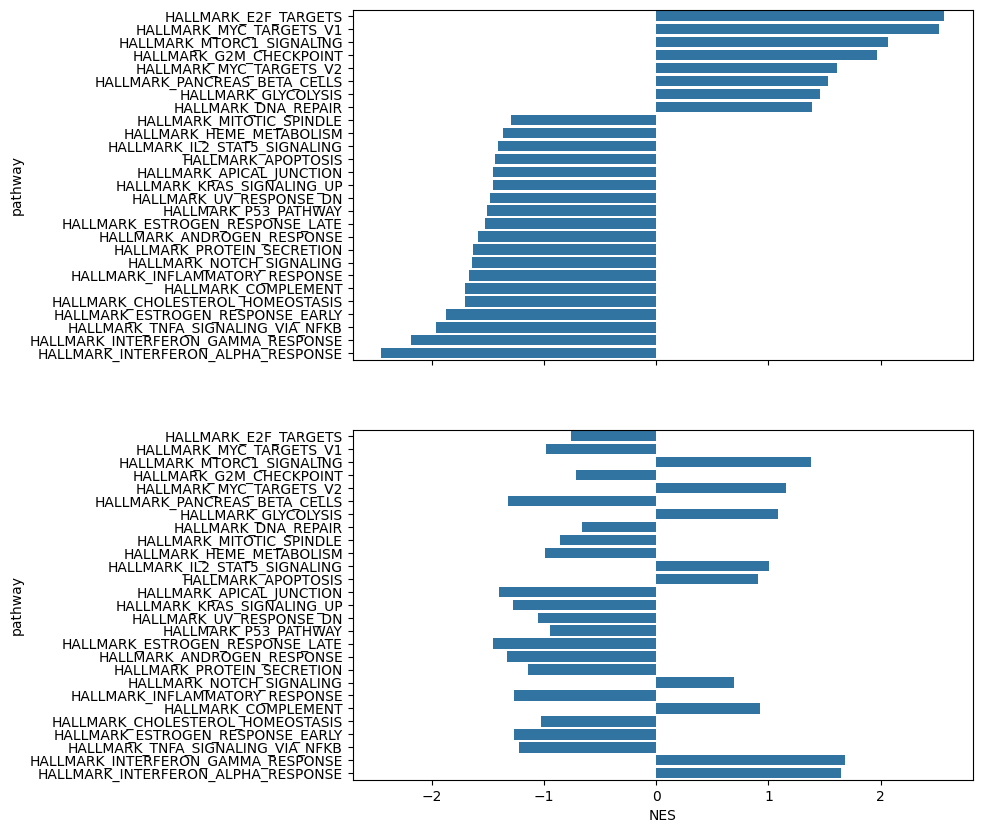

In [64]:
chen_fgsea_res = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_GeneExpressionAnalysis/fgsea/Chen.scanpy.GSEA.tsv', sep='\t')
joanito_fgsea_res = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_GeneExpressionAnalysis/fgsea/Joanito.scanpy.GSEA.tsv', sep='\t')

chen_fgsea_res = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_GeneExpressionAnalysis/fgsea/Chen.pyDESeq2.GSEA.tsv', sep='\t')
joanito_fgsea_res = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_GeneExpressionAnalysis/fgsea/Joanito.pyDESeq2.GSEA.tsv', sep='\t')
joanito_fgsea_res['neg_NES'] = [ -nes for nes in joanito_fgsea_res['NES'] ]

fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, sharey=True)
sns.barplot(data=joanito_fgsea_res[joanito_fgsea_res['padj']<=0.1], y='pathway', x='NES', ax=axes[0])
sns.barplot(data=chen_fgsea_res[chen_fgsea_res['pathway'].isin(joanito_fgsea_res[joanito_fgsea_res['padj']<=0.1]['pathway'])], y='pathway', x='NES', ax=axes[1])

In [65]:
joanito_fgsea_res[(joanito_fgsea_res['pathway']=='HALLMARK_OXIDATIVE_PHOSPHORYLATION')]

,Unnamed: 0,pathway,pval,padj,ES,NES,nMoreExtreme,size,neg_NES
12,13,HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.262458,0.328073,0.228926,1.059329,78,199,-1.059329


In [66]:
chen_fgsea_res[(chen_fgsea_res['pathway']=='HALLMARK_OXIDATIVE_PHOSPHORYLATION')]

,Unnamed: 0,pathway,pval,padj,ES,NES,nMoreExtreme,size
24,25,HALLMARK_OXIDATIVE_PHOSPHORYLATION,1.0,1.0,0.131947,0.563217,637,200


<Axes: xlabel='J', ylabel='C'>

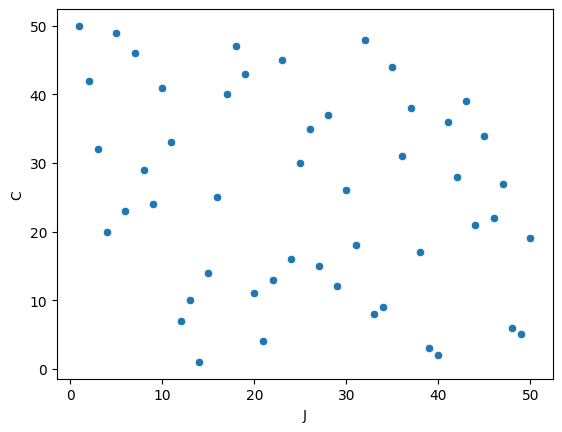

In [5]:
chen_fgsea_res.columns = ['rank'] + list(chen_fgsea_res.columns)[1:]
joanito_fgsea_res.columns = ['rank'] + list(joanito_fgsea_res.columns)[1:]

dict_pathway_to_scores = { tup.pathway : [tup.rank, chen_fgsea_res[chen_fgsea_res['pathway']==tup.pathway].iloc[0]['rank']] for tup in joanito_fgsea_res.itertuples()  }
dict_pathway_to_scores = pd.DataFrame(dict_pathway_to_scores).T
dict_pathway_to_scores.columns = ['J', 'C']

sns.scatterplot(data=dict_pathway_to_scores, x='J', y='C')

In [36]:
dict_gene_to_scores = { tup.gene : [tup.Index] for tup in Joanito_scanpy_DEGs[(Joanito_scanpy_DEGs['adjusted_pvalue']<=0.05) & 
                                                                              (Joanito_scanpy_DEGs['gene'].isin(Chen_scanpy_DEGs[(Chen_scanpy_DEGs['adjusted_pvalue']<=0.05)]['gene']))].itertuples()  }
for tup in Chen_scanpy_DEGs[(Chen_scanpy_DEGs['adjusted_pvalue']<=0.05)].itertuples():
    try: dict_gene_to_scores[tup.gene].append( tup.Index )
    except KeyError: continue

dict_gene_to_scores = pd.DataFrame(dict_gene_to_scores).T
dict_gene_to_scores.columns = ['J', 'C']
dict_gene_to_scores.iloc[-40:-20]

,J,C
KLK1,29343,26816
PSD3,29344,24342
MALAT1,29345,264
ANXA2,29346,28828
GOLM1,29348,1012
MLPH,29349,27544
CAPN8,29350,28439
FXYD5,29351,28638
NEAT1,29352,154
MYADM,29354,662


<Axes: xlabel='J', ylabel='C'>

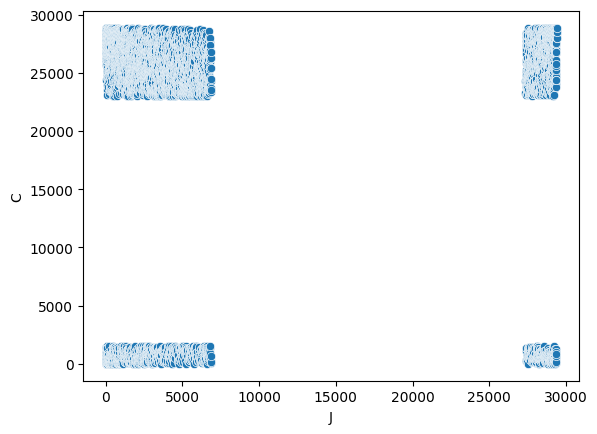

In [30]:
sns.scatterplot(data=dict_gene_to_scores, x='J', y='C', )

## DecoupleR: Functional enrichment of biological terms

In [ ]:
# https://decoupler-py.readthedocs.io/en/latest/notebooks/msigdb.html#Enrichment-with-Over-Representation-Analysis-(ORA)

In [70]:
msigdb = dc.get_resource('MSigDB')

In [71]:
# Filter by hallmark
msigdb_hallmark = msigdb[msigdb['collection']=='hallmark'].copy()

# Remove duplicated entries
msigdb_hallmark = msigdb_hallmark[~msigdb_hallmark.duplicated(['geneset', 'genesymbol'])]
msigdb_hallmark

,genesymbol,collection,geneset
233,MAFF,hallmark,HALLMARK_IL2_STAT5_SIGNALING
250,MAFF,hallmark,HALLMARK_COAGULATION
270,MAFF,hallmark,HALLMARK_HYPOXIA
373,MAFF,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,HALLMARK_COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450526,GCG,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,HALLMARK_PANCREAS_BETA_CELLS


In [90]:
set(adata_epi_joanito_tumor.obs['MSI_class'])

{'MSI-H', 'MSI-I', 'MSI-L'}

In [99]:
adata_epi_joanito_tumor_1   = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['MSI_class']!='MSI-I'].copy()
adata_epi_chen_tumor_1      = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['MSI_class']!='MSI-I'].copy()

### Joanito et al

In [100]:
dc.run_ora(
    mat=adata_epi_joanito_tumor_1,
    net=msigdb_hallmark,
    source='geneset',
    target='genesymbol',
    verbose=True
)

4305 features of mat are empty, they will be removed.
Running ora on mat with 1700 samples and 25083 targets for 50 sources.


  0%|          | 0/1700 [00:00<?, ?it/s]

In [101]:
acts_joanito = dc.get_acts(adata_epi_joanito_tumor_1, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts_joanito.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts_joanito.X[~np.isfinite(acts_joanito.X)] = max_e

acts_joanito

AnnData object with n_obs × n_vars = 1700 × 50
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'leiden', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'BiopsySite2', 'Manual_CellType_lvl_1', 'MSI_class'
    uns: 'Author_CellType_lvl_1_colors', 'BiopsySite_colors', 'Manual_CellType_lvl_1_colors', 'PatientID_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'dendrogram_PatientID', 'dendrogram_MSI_class'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

In [102]:
df_joanito = dc.rank_sources_groups(acts_joanito, groupby='MSI_class', reference='rest', method='wilcoxon')

n_markers = 3
joanito_source_markers = df_joanito.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
joanito_source_markers

{'MSI-H': ['HALLMARK_MTORC1_SIGNALING',
  'HALLMARK_MYC_TARGETS_V1',
  'HALLMARK_E2F_TARGETS'],
 'MSI-L': ['HALLMARK_ESTROGEN_RESPONSE_EARLY',
  'HALLMARK_KRAS_SIGNALING_UP',
  'HALLMARK_INTERFERON_ALPHA_RESPONSE']}

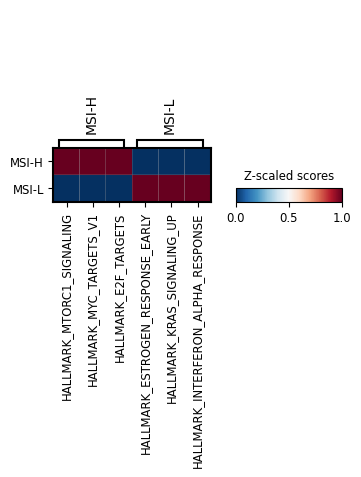

In [103]:
sc.pl.matrixplot(acts_joanito, joanito_source_markers, 'MSI_class', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

### Chen et al

In [104]:
dc.run_ora(
    mat=adata_epi_chen_tumor_1,
    net=msigdb_hallmark,
    source='geneset',
    target='genesymbol',
    verbose=True
)

892 features of mat are empty, they will be removed.
Running ora on mat with 8723 samples and 27959 targets for 50 sources.


  0%|          | 0/8723 [00:00<?, ?it/s]

In [105]:
acts_chen = dc.get_acts(adata_epi_chen_tumor_1, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts_chen.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts_chen.X[~np.isfinite(acts_chen.X)] = max_e

acts_chen

AnnData object with n_obs × n_vars = 8723 × 50
    obs: 'doublet_score', 'predicted_doublet', 'SampleID', 'PatientID', 'BiopsySite', 'Accession', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2', 'n_genes', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Response', 'leiden', 'Manual_CellType_lvl_1', 'TumorLocation', 'TumorStage', 'TumorRegressionRatio', 'CancerType', 'Age', 'iCMS3_up', 'iCMS3_dw', 'iCMS2_up', 'iCMS2_dw', 'MSI_class'
    uns: 'Author_CellType_lvl_1_colors', 'BiopsySite_colors', 'CancerType_colors', 'Manual_CellType_lvl_1_colors', 'PatientID_colors', 'TumorLocation_colors', 'TumorStage_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'dend

In [106]:
df_chen = dc.rank_sources_groups(acts_chen, groupby='MSI_class', reference='rest', method='wilcoxon')

n_markers = 3
chen_source_markers = df_chen.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
chen_source_markers

{'MSI-H': ['HALLMARK_IL6_JAK_STAT3_SIGNALING',
  'HALLMARK_HEDGEHOG_SIGNALING',
  'HALLMARK_HYPOXIA'],
 'MSI-L': ['HALLMARK_ANDROGEN_RESPONSE',
  'HALLMARK_PROTEIN_SECRETION',
  'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY']}

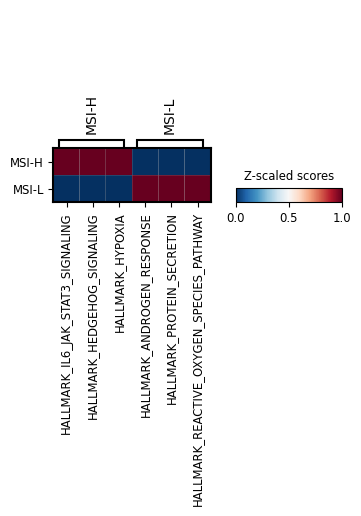

In [107]:
sc.pl.matrixplot(acts_chen, chen_source_markers, 'MSI_class', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', )

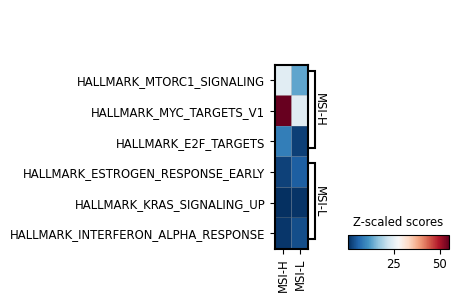

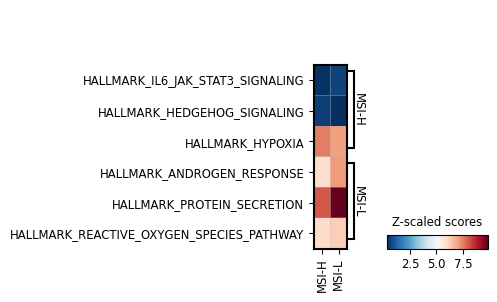

In [111]:
sc.pl.matrixplot(acts_joanito, joanito_source_markers, 'MSI_class', dendrogram=False, 
                 # standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', swap_axes=True,)

sc.pl.matrixplot(acts_joanito, chen_source_markers, 'MSI_class', dendrogram=False, 
                 # standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', swap_axes=True,)

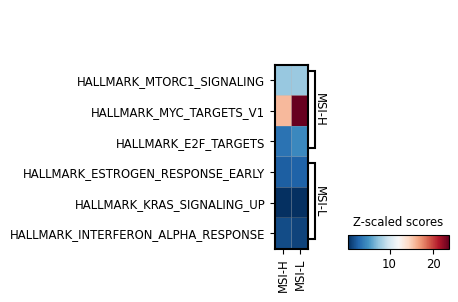

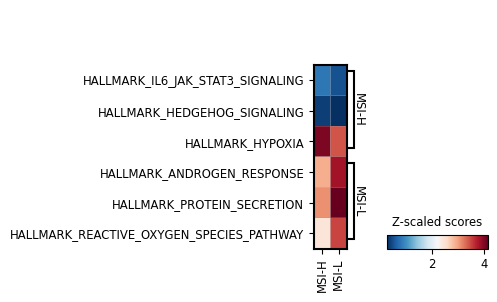

In [112]:
sc.pl.matrixplot(acts_chen, joanito_source_markers, 'MSI_class', dendrogram=False, 
                 # standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', swap_axes=True,)

sc.pl.matrixplot(acts_chen, chen_source_markers, 'MSI_class', dendrogram=False, 
                 # standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', swap_axes=True,)

## DecoupleR: GSEA using PyDESeq2 results

In [336]:
Joanito_scanpy_DEGs_copy = Joanito_scanpy_DEGs.copy()
Joanito_scanpy_DEGs_copy.index = Joanito_scanpy_DEGs_copy['gene']
Joanito_scanpy_DEGs_copy.columns = ['gene', 'stat', 'log2FoldChange', 'pvalue', 'padj', 'MSI_class']
Joanito_scanpy_DEGs_copy['baseMean'] = 'NA'
Joanito_scanpy_DEGs_copy['lfcSE'] = 'NA'

Joanito_scanpy_DEGs_copy = Joanito_scanpy_DEGs_copy[['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']]
Joanito_scanpy_DEGs_copy.index.name = None 
Joanito_scanpy_DEGs_copy

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
MARCKSL1,NA,3.570664,NA,29.091002,4.665734e-186,2.285277e-182
LDHB,NA,8.693336,NA,28.779348,3.889981e-182,1.143188e-178
PRSS21,NA,32.364716,NA,28.674648,7.902524e-181,2.111267e-177
NUPR1,NA,8.487197,NA,28.277336,6.566849e-176,1.206166e-172
ATP5F1D,NA,3.997488,NA,27.919003,1.568836e-171,2.712056e-168
...,...,...,...,...,...,...
IFI27,NA,-10.107083,NA,-29.095657,4.074007e-186,2.285277e-182
LGALS4,NA,-3.957475,NA,-29.172123,4.379107e-187,3.217330e-183
TFF1,NA,-7.315935,NA,-29.180779,3.400816e-187,3.217330e-183
C19orf33,NA,-8.942307,NA,-29.246141,5.027312e-188,7.387133e-184


In [67]:
Joanito_pydeseq2_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')
Chen_pydeseq2_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')

In [68]:
Joanito_pydeseq2_DEGs.index = Joanito_pydeseq2_DEGs['Unnamed: 0']
Joanito_pydeseq2_DEGs.drop(['Unnamed: 0'], axis=1, inplace=True)
Joanito_pydeseq2_DEGs.index.name = None

Chen_pydeseq2_DEGs.index = Chen_pydeseq2_DEGs['Unnamed: 0']
Chen_pydeseq2_DEGs.drop(['Unnamed: 0'], axis=1, inplace=True)
Chen_pydeseq2_DEGs.index.name = None

### HALLMARK

In [72]:
# Run ora
enr_pvals_joanito = dc.get_ora_df(
    df=Joanito_pydeseq2_DEGs,
    net=msigdb_hallmark,
    source='geneset',
    target='genesymbol'
)

enr_pvals_chen = dc.get_ora_df(
    df=Chen_pydeseq2_DEGs,
    net=msigdb_hallmark,
    source='geneset',
    target='genesymbol'
)

In [73]:
enr_pvals_joanito.sort_values('Combined score', inplace=True)
enr_pvals_chen.sort_values('Combined score', inplace=True)
enr_pvals_joanito.reset_index(inplace=True, drop=True)
enr_pvals_chen.reset_index(inplace=True, drop=True)

PearsonRResult(statistic=0.9767472822488397, pvalue=9.269468046062853e-34)

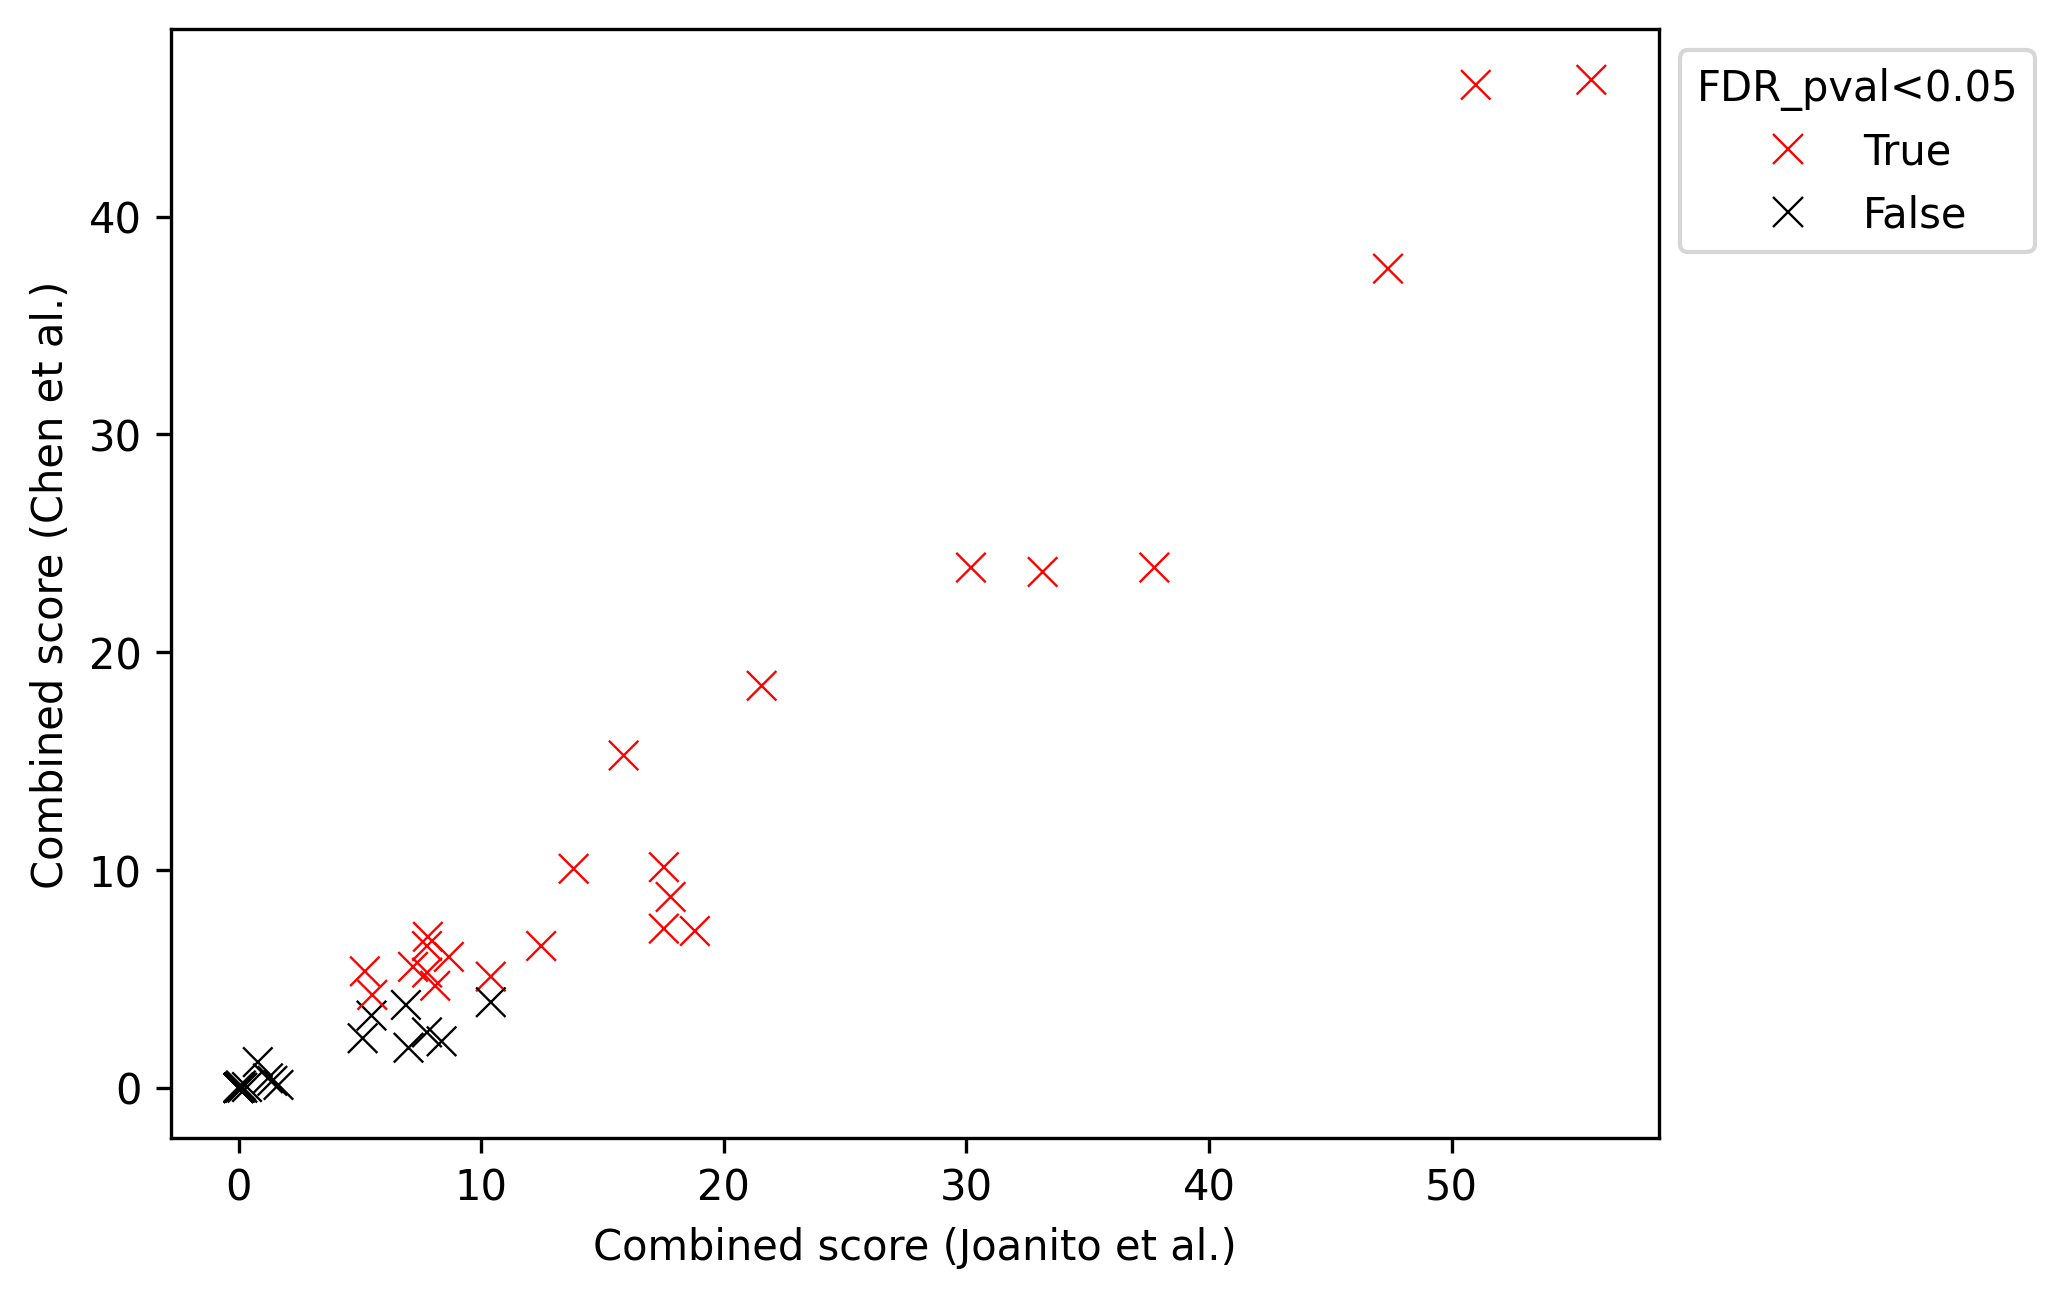

In [74]:
dict_Term_to_rank = { tup.Term : [list(tup)[7], list(tup)[5]] for tup in enr_pvals_joanito.itertuples() }

for tup in enr_pvals_chen.itertuples():
    dict_Term_to_rank[tup.Term].append(list(tup)[7])
    dict_Term_to_rank[tup.Term].append(list(tup)[5])
dict_Term_to_rank = pd.DataFrame(dict_Term_to_rank).T
dict_Term_to_rank.reset_index(inplace=True)
dict_Term_to_rank.columns = ['Term', 
                             'Combined score (Joanito et al.)', 'FDR_pval_J', 
                             'Combined score (Chen et al.)', 'FDR_pval_C', ]
dict_Term_to_rank['Joanito_isSig'] = [ bool(tup.FDR_pval_J<=0.05) for tup in dict_Term_to_rank.itertuples() ]
dict_Term_to_rank['Chen_isSig'] = [ bool(tup.FDR_pval_C<=0.05) for tup in dict_Term_to_rank.itertuples() ]
dict_Term_to_rank['both_sig'] = [ bool(tup.Joanito_isSig==True and tup.Chen_isSig==True) for tup in dict_Term_to_rank.itertuples() ]

plt.figure(dpi=300)
ax = sns.scatterplot(data=dict_Term_to_rank, 
            x='Combined score (Joanito et al.)',
            y='Combined score (Chen et al.)',
            color='black', 
            hue='both_sig', 
            palette={False : 'black', True : 'red'}, 
            # legend=None,
            hue_order=[True, False],
            s=50, marker='x'
            )

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='FDR_pval<0.05')

import scipy.stats
scipy.stats.pearsonr( dict_Term_to_rank['Combined score (Joanito et al.)'], dict_Term_to_rank['Combined score (Chen et al.)'] )

In [341]:
dict_Term_to_rank.sort_values('Combined score (Joanito et al.)', ascending=False)

,Term,Combined score (Joanito et al.),FDR_pval_J,Combined score (Chen et al.),FDR_pval_C,Joanito_isSig,Chen_isSig,both_sig
49,HALLMARK_OXIDATIVE_PHOSPHORYLATION,5.576052e+01,3.824253e-18,4.628837e+01,7.787268e-16,True,True,True
48,HALLMARK_MITOTIC_SPINDLE,5.099668e+01,6.673772e-17,4.605516e+01,7.787268e-16,True,True,True
47,HALLMARK_E2F_TARGETS,4.738026e+01,6.483890e-16,3.761547e+01,4.006753e-13,True,True,True
46,HALLMARK_MTORC1_SIGNALING,3.774759e+01,6.590708e-13,2.388804e+01,1.333204e-08,True,True,True
45,HALLMARK_DNA_REPAIR,3.314285e+01,2.850484e-11,2.368736e+01,1.787657e-08,True,True,True
44,HALLMARK_G2M_CHECKPOINT,3.018975e+01,1.358061e-10,2.388804e+01,1.333204e-08,True,True,True
43,HALLMARK_INTERFERON_ALPHA_RESPONSE,2.156074e+01,2.157396e-07,1.846038e+01,1.449757e-06,True,True,True
42,HALLMARK_P53_PATHWAY,1.880764e+01,7.116408e-07,7.199655e+00,5.366253e-03,True,True,True
41,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,1.780960e+01,1.964098e-06,8.763700e+00,2.021397e-03,True,True,True
39,HALLMARK_MYC_TARGETS_V1,1.753028e+01,1.563765e-06,1.013132e+01,6.235315e-04,True,True,True


In [246]:
enr_pvals_joanito[(enr_pvals_joanito['FDR p-value']<=0.05)].sort_values('Combined score', ascending=False).head(10)

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
49,HALLMARK_OXIDATIVE_PHOSPHORYLATION,200,0.995000,7.648506e-20,3.824253e-18,1.266790,55.760518,ABCB7;ACAA1;ACAA2;ACADM;ACADSB;ACADVL;ACAT1;AC...
48,HALLMARK_MITOTIC_SPINDLE,199,0.989950,2.669509e-18,6.673772e-17,1.260278,50.996678,ABI1;ABL1;ABR;ACTN4;AKAP13;ALMS1;ALS2;ANLN;APC...
47,HALLMARK_E2F_TARGETS,200,0.985000,3.890334e-17,6.483890e-16,1.253929,47.380260,AK2;ANP32E;ASF1A;ASF1B;ATAD2;AURKA;AURKB;BARD1...
46,HALLMARK_MTORC1_SIGNALING,200,0.970000,5.272566e-14,6.590708e-13,1.234644,37.747588,ABCF2;ACACA;ACLY;ACSL3;ACTR2;ACTR3;ADD3;ADIPOR...
45,HALLMARK_DNA_REPAIR,150,0.980000,2.850484e-12,2.850484e-11,1.246744,33.142846,AAAS;ADA;ADCY6;ADRM1;AGO4;AK1;AK3;ALYREF;APRT;...
44,HALLMARK_G2M_CHECKPOINT,200,0.955000,1.629674e-11,1.358061e-10,1.215366,30.189755,ABL1;AMD1;ARID4A;ATF5;ATRX;AURKA;AURKB;BARD1;B...
43,HALLMARK_INTERFERON_ALPHA_RESPONSE,97,0.979381,3.020354e-08,2.157396e-07,1.245184,21.560743,ADAR;B2M;BATF2;BST2;CASP1;CASP8;CCRL2;CD47;CD7...
42,HALLMARK_P53_PATHWAY,199,0.924623,1.138625e-07,7.116408e-07,1.176340,18.807639,ABAT;ABCC5;ABHD4;ACVR1B;ADA;AEN;AK1;ALOX15B;AN...
41,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,113,0.955752,4.321017e-07,1.964098e-06,1.215291,17.809604,ALDH18A1;ARFGAP1;ASNS;ATF3;ATF4;ATF6;ATP6V0D1;...
39,HALLMARK_MYC_TARGETS_V1,200,0.920000,3.127531e-07,1.563765e-06,1.170413,17.530278,ABCE1;ACP1;AIMP2;AP3S1;APEX1;BUB3;C1QBP;CAD;CA...


In [244]:
enr_pvals_chen[(enr_pvals_chen['FDR p-value']<=0.05)].sort_values('Combined score', ascending=False)

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
49,HALLMARK_OXIDATIVE_PHOSPHORYLATION,200,1.000000,2.570612e-17,7.787268e-16,1.211744,46.288375,ABCB7;ACAA1;ACAA2;ACADM;ACADSB;ACADVL;ACAT1;AC...
48,HALLMARK_MITOTIC_SPINDLE,199,1.000000,3.114907e-17,7.787268e-16,1.211731,46.055161,ABI1;ABL1;ABR;ACTN4;AKAP13;ALMS1;ALS2;ANLN;APC...
47,HALLMARK_E2F_TARGETS,200,0.990000,2.404052e-14,4.006753e-13,1.199510,37.615470,AK2;ANP32E;ASF1A;ASF1B;ATAD2;AURKA;AURKB;BARD1...
45,HALLMARK_MTORC1_SIGNALING,200,0.965000,1.333204e-09,1.333204e-08,1.168938,23.888040,ABCF2;ACACA;ACLY;ACSL3;ACTR2;ACTR3;ADD3;ADIPOR...
46,HALLMARK_G2M_CHECKPOINT,200,0.965000,1.333204e-09,1.333204e-08,1.168938,23.888040,ABL1;AMD1;ARID4A;ATF5;ATRX;AURKA;AURKB;BARD1;B...
44,HALLMARK_DNA_REPAIR,150,0.980000,2.145188e-09,1.787657e-08,1.186739,23.687360,AAAS;ADA;ADCY6;ADRM1;AGO4;AK1;AK3;ALYREF;APRT;...
43,HALLMARK_INTERFERON_ALPHA_RESPONSE,97,0.989691,2.029660e-07,1.449757e-06,1.197930,18.460375,ADAR;B2M;BATF2;BST2;C1S;CASP1;CASP8;CCRL2;CD47...
42,HALLMARK_PROTEIN_SECRETION,96,0.979167,2.558715e-06,1.599197e-05,1.185174,15.260313,ABCA1;ADAM10;ANP32E;AP1G1;AP2B1;AP2M1;AP2S1;AP...
41,HALLMARK_MYC_TARGETS_V1,200,0.920000,1.122357e-04,6.235315e-04,1.113955,10.131323,ABCE1;ACP1;AIMP2;AP3S1;APEX1;BUB3;C1QBP;CAD;CA...
40,HALLMARK_MYC_TARGETS_V2,58,0.982759,2.125908e-04,1.062954e-03,1.189165,10.055748,AIMP2;BYSL;CBX3;CDK4;DCTPP1;DDX18;DUSP2;EXOSC5...


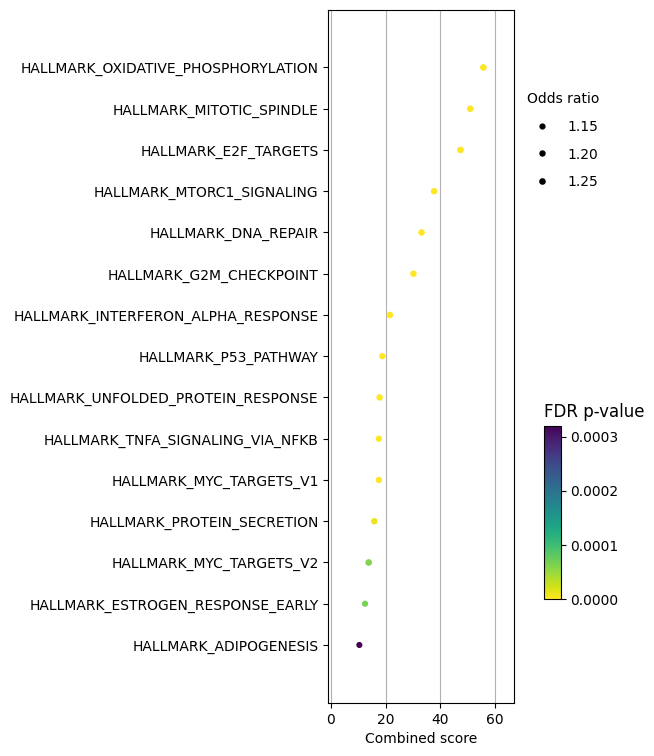

In [155]:
dc.plot_dotplot(
    enr_pvals_joanito.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=0.5,
    figsize=(3, 9)
)

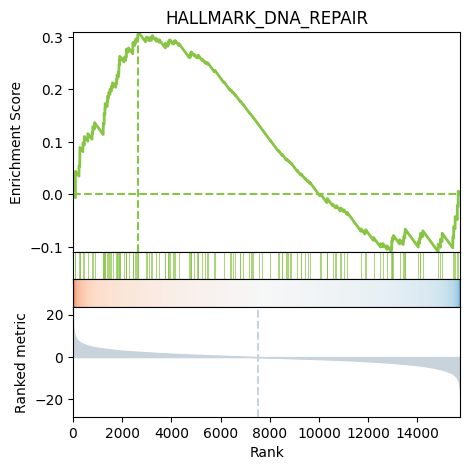

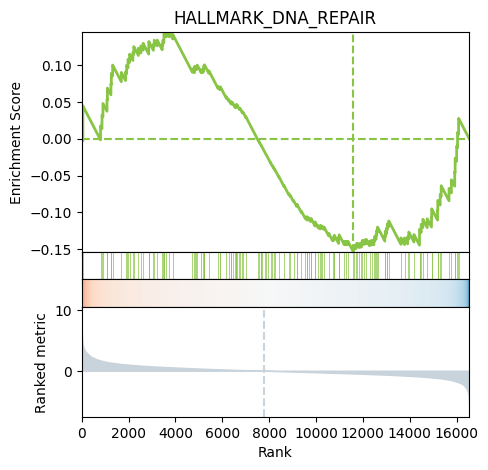

In [247]:
term_of_interest = 'HALLMARK_DNA_REPAIR'

dc.plot_running_score(
    df=Joanito_pydeseq2_DEGs,
    stat='stat',
    net=msigdb_hallmark,
    source='geneset',
    target='genesymbol',
    set_name=term_of_interest,
    # ax=axes[0]
)

dc.plot_running_score(
    df=Chen_pydeseq2_DEGs,
    stat='stat',
    net=msigdb_hallmark,
    source='geneset',
    target='genesymbol',
    set_name=term_of_interest,
    # ax=axes[1]
)

### C6: oncogenic signatures

In [343]:
msigdb_oncogenic_signatures = msigdb[msigdb['collection']=='go_biological_process'].copy()
# Remove duplicated entries
msigdb_oncogenic_signatures = msigdb_oncogenic_signatures[~msigdb_oncogenic_signatures.duplicated(['geneset', 'genesymbol'])]
msigdb_oncogenic_signatures

,genesymbol,collection,geneset
33,MAFF,go_biological_process,GOBP_EMBRYO_DEVELOPMENT
44,MAFF,go_biological_process,GOBP_POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS
82,MAFF,go_biological_process,GOBP_REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIA...
94,MAFF,go_biological_process,GOBP_EMBRYO_DEVELOPMENT_ENDING_IN_BIRTH_OR_EGG...
108,MAFF,go_biological_process,GOBP_IN_UTERO_EMBRYONIC_DEVELOPMENT
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [344]:
# Run ora
enr_pvals_joanito = dc.get_ora_df(
    df=Joanito_pydeseq2_DEGs,
    net=msigdb_oncogenic_signatures,
    source='geneset',
    target='genesymbol'
)

enr_pvals_chen = dc.get_ora_df(
    df=Chen_pydeseq2_DEGs,
    net=msigdb_oncogenic_signatures,
    source='geneset',
    target='genesymbol'
)

In [345]:
enr_pvals_joanito.sort_values('Combined score', inplace=True)
enr_pvals_chen.sort_values('Combined score', inplace=True)
enr_pvals_joanito.reset_index(inplace=True, drop=True)
enr_pvals_chen.reset_index(inplace=True, drop=True)

In [346]:
enr_pvals_joanito[enr_pvals_joanito['Term']=='DESCARTES_FETAL_EYE_BIPOLAR_CELLS']

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features


In [347]:
enr_pvals_chen.shape
enr_pvals_chen[enr_pvals_chen['Term']=='DESCARTES_FETAL_EYE_BIPOLAR_CELLS']

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features


PearsonRResult(statistic=0.9484784863461563, pvalue=0.0)

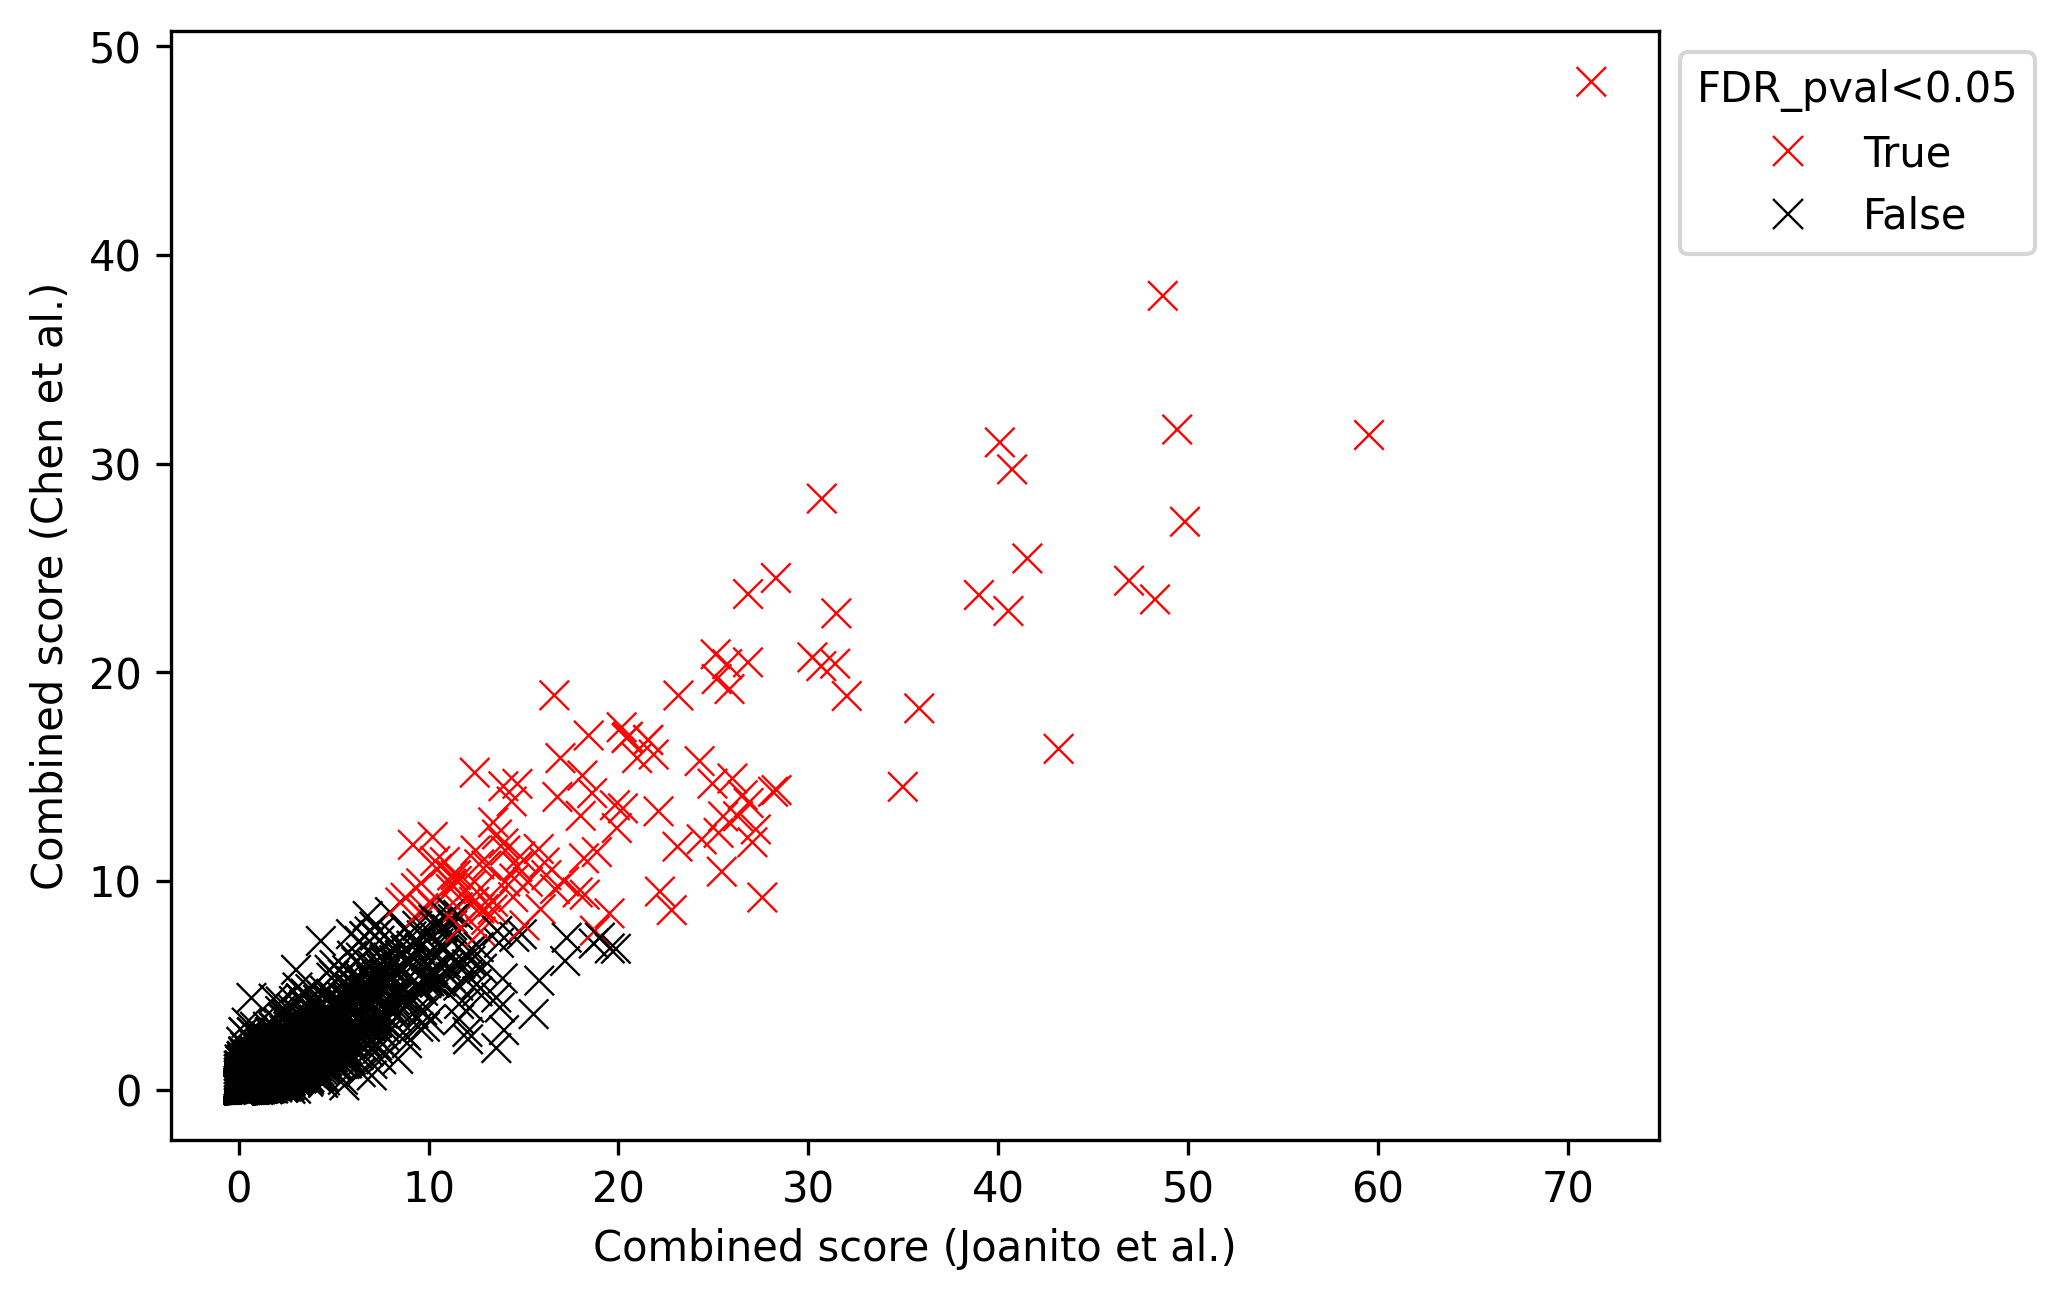

In [348]:
dict_Term_to_rank = { tup.Term : [list(tup)[7], list(tup)[5]] for tup in enr_pvals_joanito[(enr_pvals_joanito['Term'].isin(enr_pvals_chen['Term']))].itertuples() }

for tup in enr_pvals_chen[(enr_pvals_chen['Term'].isin(enr_pvals_joanito['Term']))].itertuples():
    dict_Term_to_rank[tup.Term].append(list(tup)[7])
    dict_Term_to_rank[tup.Term].append(list(tup)[5])

dict_Term_to_rank = pd.DataFrame(dict_Term_to_rank).T
dict_Term_to_rank.reset_index(inplace=True)
dict_Term_to_rank.columns = ['Term', 
                             'Combined score (Joanito et al.)', 'FDR_pval_J', 
                             'Combined score (Chen et al.)', 'FDR_pval_C', ]
dict_Term_to_rank['Joanito_isSig'] = [ bool(tup.FDR_pval_J<=0.05) for tup in dict_Term_to_rank.itertuples() ]
dict_Term_to_rank['Chen_isSig'] = [ bool(tup.FDR_pval_C<=0.05) for tup in dict_Term_to_rank.itertuples() ]
dict_Term_to_rank['both_sig'] = [ bool(tup.Joanito_isSig==True and tup.Chen_isSig==True) for tup in dict_Term_to_rank.itertuples() ]

plt.figure(dpi=300)
ax = sns.scatterplot(data=dict_Term_to_rank, 
            x='Combined score (Joanito et al.)',
            y='Combined score (Chen et al.)',
            color='black', 
            hue='both_sig', 
            palette={False : 'black', True : 'red'}, 
            # legend=None,
            hue_order=[True, False],
            s=50, marker='x'
            )

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='FDR_pval<0.05')

import scipy.stats
scipy.stats.pearsonr( dict_Term_to_rank['Combined score (Joanito et al.)'], dict_Term_to_rank['Combined score (Chen et al.)'] )

In [352]:
set(dict_Term_to_rank['Term'])

{'GOBP_ACTIVATION_OF_PHOSPHOLIPASE_C_ACTIVITY',
 'GOBP_NEUROTRANSMITTER_UPTAKE',
 'GOBP_OLEFINIC_COMPOUND_METABOLIC_PROCESS',
 'GOBP_UTERINE_SMOOTH_MUSCLE_CONTRACTION',
 'GOBP_REGULATION_OF_INWARD_RECTIFIER_POTASSIUM_CHANNEL_ACTIVITY',
 'GOBP_AGGRESOME_ASSEMBLY',
 'GOBP_NEURON_PROJECTION_GUIDANCE',
 'GOBP_NEGATIVE_REGULATION_OF_PROTEIN_CONTAINING_COMPLEX_ASSEMBLY',
 'GOBP_PROLINE_IMPORT_ACROSS_PLASMA_MEMBRANE',
 'GOBP_EMBRYO_IMPLANTATION',
 'GOBP_RUFFLE_ASSEMBLY',
 'GOBP_RECEPTOR_GUANYLYL_CYCLASE_SIGNALING_PATHWAY',
 'GOBP_RESPONSE_TO_COPPER_ION',
 'GOBP_CELLULAR_RESPONSE_TO_PEPTIDOGLYCAN',
 'GOBP_NEGATIVE_REGULATION_OF_NEUROINFLAMMATORY_RESPONSE',
 'GOBP_NEUROFILAMENT_CYTOSKELETON_ORGANIZATION',
 'GOBP_INTEGRATED_STRESS_RESPONSE_SIGNALING',
 'GOBP_COMMON_BILE_DUCT_DEVELOPMENT',
 'GOBP_POSITIVE_REGULATION_OF_MACROPHAGE_MIGRATION',
 'GOBP_POSITIVE_REGULATION_OF_DEACETYLASE_ACTIVITY',
 'GOBP_REGULATION_OF_RELAXATION_OF_CARDIAC_MUSCLE',
 'GOBP_PLATELET_ACTIVATION',
 'GOBP_POST_EMBRYONIC_A

In [354]:
dict_Term_to_rank[dict_Term_to_rank['Term']=='GOBP_INTESTINAL_EPITHELIAL_CELL_DEVELOPMENT']

,Term,Combined score (Joanito et al.),FDR_pval_J,Combined score (Chen et al.),FDR_pval_C,Joanito_isSig,Chen_isSig,both_sig
5649,GOBP_INTESTINAL_EPITHELIAL_CELL_DEVELOPMENT,1.152519,1.0,0.718568,1.0,False,False,False


In [349]:
dict_Term_to_rank.sort_values('Combined score (Joanito et al.)', ascending=False).head(5)

,Term,Combined score (Joanito et al.),FDR_pval_J,Combined score (Chen et al.),FDR_pval_C,Joanito_isSig,Chen_isSig,both_sig
7724,GOBP_CELLULAR_RESPONSE_TO_DNA_DAMAGE_STIMULUS,71.228985,4.052749e-23,48.293674,2.123853e-15,True,True,True
7723,GOBP_INTRACELLULAR_TRANSPORT,59.522858,5.026489e-20,31.370798,6.853691e-10,True,True,True
7722,GOBP_MITOTIC_CELL_CYCLE_PROCESS,49.830793,5.670889e-16,27.214771,2.254927e-08,True,True,True
7721,GOBP_MRNA_METABOLIC_PROCESS,49.420760,6.825001e-16,31.632832,9.518961e-10,True,True,True
7720,GOBP_DNA_REPAIR,48.664605,1.330670e-15,38.035915,1.132453e-11,True,True,True


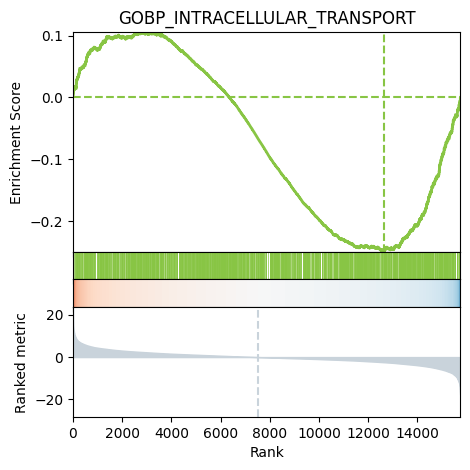

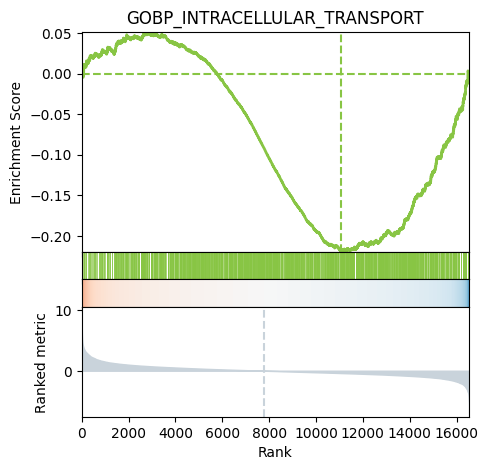

In [299]:
term_of_interest = 'GOBP_INTRACELLULAR_TRANSPORT'

dc.plot_running_score(
    df=Joanito_pydeseq2_DEGs,
    stat='stat',
    net=msigdb_oncogenic_signatures,
    source='geneset',
    target='genesymbol',
    set_name=term_of_interest,
    # ax=axes[0]
)

dc.plot_running_score(
    df=Chen_pydeseq2_DEGs,
    stat='stat',
    net=msigdb_oncogenic_signatures,
    source='geneset',
    target='genesymbol',
    set_name=term_of_interest,
    # ax=axes[1]
)

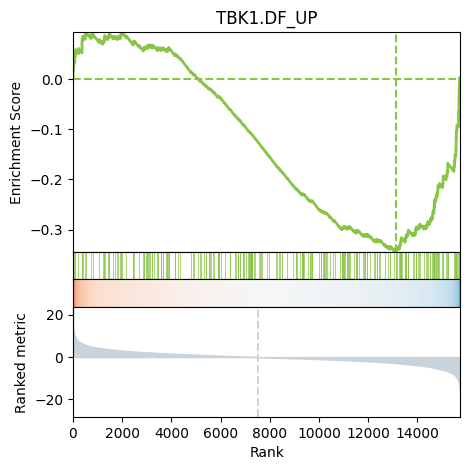

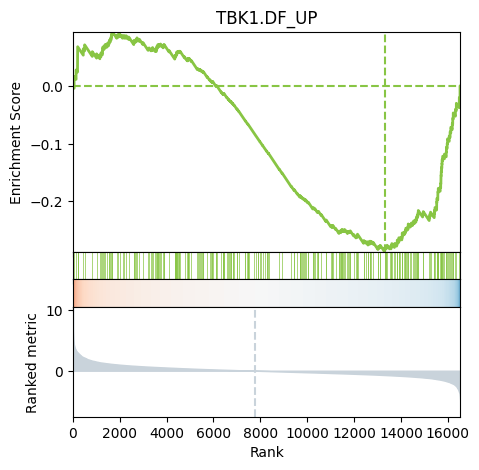

In [ ]:
term_of_interest = 'GOBP_INTRACELLULAR_TRANSPORT'

dc.plot_running_score(
    df=Joanito_pydeseq2_DEGs,
    stat='stat',
    net=msigdb_oncogenic_signatures,
    source='geneset',
    target='genesymbol',
    set_name=term_of_interest,
    # ax=axes[0]
)

dc.plot_running_score(
    df=Chen_pydeseq2_DEGs,
    stat='stat',
    net=msigdb_oncogenic_signatures,
    source='geneset',
    target='genesymbol',
    set_name=term_of_interest,
    # ax=axes[1]
)

## DecoupleR: GSEA using Scanpy

### Chen et al

In [373]:
sc.tl.rank_genes_groups(adata_epi_chen_tumor_1, groupby='MSI_class', method='wilcoxon')

,names,scores,logfoldchanges,pvals,pvals_adj
0,REG1A,49.196442,6.853072,0.000000e+00,0.000000e+00
1,PIGR,34.817936,2.090109,1.302077e-265,1.977169e-262
2,MUC6,32.104008,9.448875,3.876344e-226,4.142089e-223
3,PRUNE2,31.753098,4.886324,2.877546e-221,2.965003e-218
4,RGMB,29.466511,3.172198,7.736148e-191,5.873569e-188
...,...,...,...,...,...
28846,S100P,-42.087227,-2.033902,0.000000e+00,0.000000e+00
28847,CRIP1,-42.180271,-1.991039,0.000000e+00,0.000000e+00
28848,S100A10,-44.595913,-2.086068,0.000000e+00,0.000000e+00
28849,REG4,-45.422131,-3.260101,0.000000e+00,0.000000e+00


In [392]:
# extract scores
wilcoxon_stats = (
    # Get dataframe of DE results for condition vs. rest
    sc.get.rank_genes_groups_df(adata_epi_chen_tumor_1, 'MSI-H', key='rank_genes_groups')
    # Subset to highly variable genes
    .set_index("names")
    # Sort by absolute score
    .sort_values("scores", key=np.abs, ascending=False)[
        # Format for decoupler
        ["scores"]
    ]
    .rename_axis(["MSI-H"], axis=1)
)

wilcoxon_stats

MSI-H,scores
names,
S100A6,-50.490971
REG1A,49.196442
REG4,-45.422131
S100A10,-44.595913
CRIP1,-42.180271
...,...
IGHV3-38,0.000000
AC098595.1,0.000000
IGHV3-22,0.000000


In [395]:
scores, norm, pvals = dc.run_gsea(
    wilcoxon_stats.T,
    msigdb_hallmark,
    source="geneset",
    target="genesymbol",
)

In [396]:
gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

In [408]:
gsea_results.reset_index(inplace=True)

In [440]:
gsea_results_c = list() 
for tup in gsea_results.itertuples():
    gsea_results_c.append( [tup.source, tup.score, tup.pval, tup.norm] )
gsea_results_c = pd.DataFrame(gsea_results_c, columns=['source', 'score', 'pval', 'norm'])

<Axes: xlabel='norm', ylabel='source'>

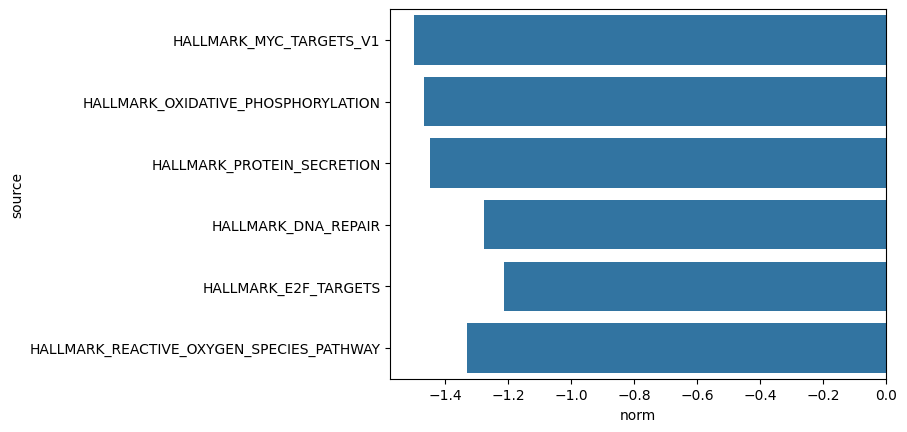

In [442]:
sns.barplot(data=gsea_results_c[(gsea_results_c['pval']<=0.05)], y='source', x='norm')

In [402]:
gsea_results[gsea_results.index=='HALLMARK_MITOTIC_SPINDLE']

,score,norm,pval
source,,,
HALLMARK_MITOTIC_SPINDLE,-0.533181,-1.105569,0.200602


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


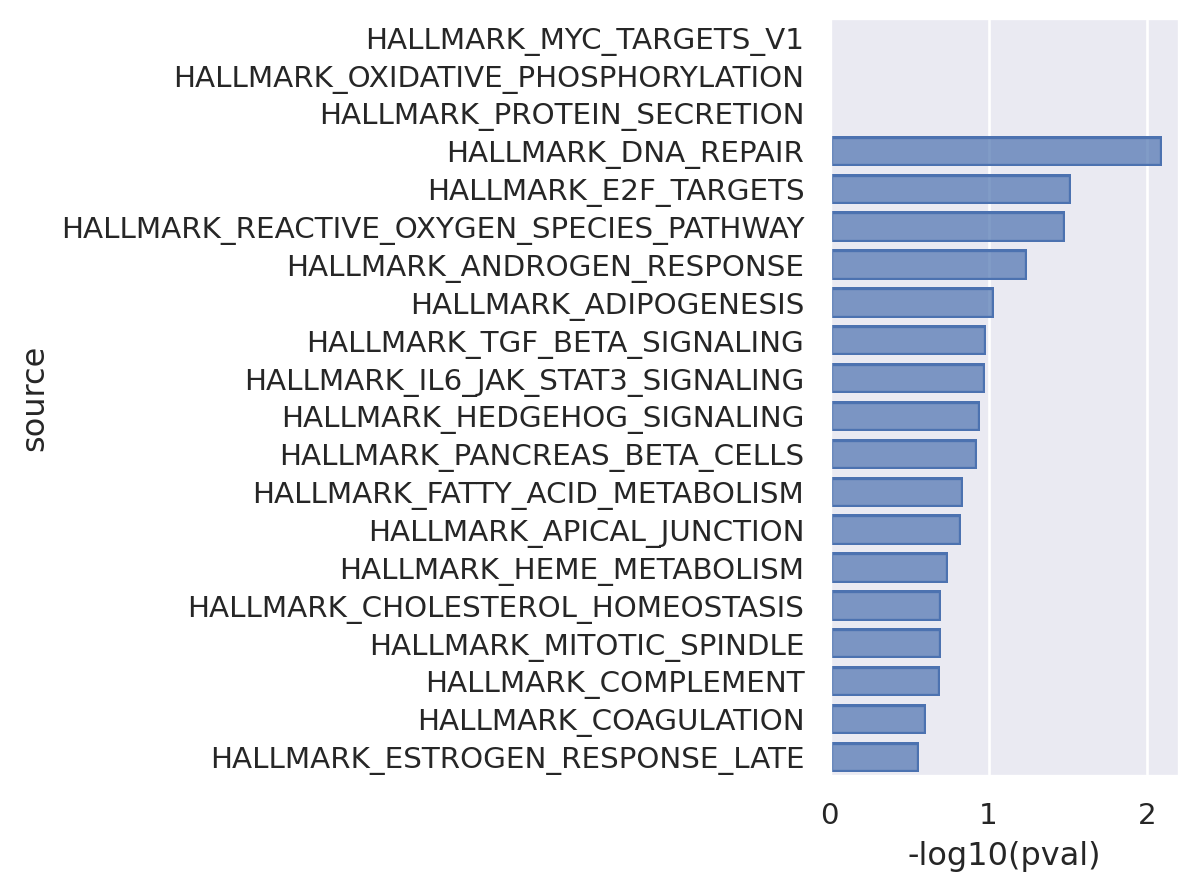

In [438]:
import seaborn.objects as so
(
    so.Plot(
        data=(
            gsea_results_c.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In [450]:
Joanito_scanpy_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')
Joanito_scanpy_DEGs[(Joanito_scanpy_DEGs['MSI_class']=='MSI_H')][['gene', 'score']].reset_index(drop=True).to_csv('/node200data/shared/gyumin/Joanito.scanpy.tsv', sep='\t', index=False)

Chen_scanpy_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')
Chen_scanpy_DEGs[(Chen_scanpy_DEGs['MSI_class']=='MSI_H')][['gene', 'score']].reset_index(drop=True).to_csv('/node200data/shared/gyumin/Chen.scanpy.tsv', sep='\t', index=False)

In [455]:
Joanito_pyDESeq2_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')
Joanito_pyDESeq2_DEGs.columns = [ 'gene' ] + list(Joanito_pyDESeq2_DEGs.columns)[1:]
Joanito_pyDESeq2_DEGs[['gene', 'stat']].reset_index(drop=True).to_csv('/node200data/shared/gyumin/Joanito.pyDESeq2.tsv', sep='\t', index=False)

Chen_pyDESeq2_DEGs = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/PyDESeq2_out.summary.tsv', sep='\t')
Chen_pyDESeq2_DEGs.columns = [ 'gene' ] + list(Chen_pyDESeq2_DEGs.columns)[1:]
Chen_pyDESeq2_DEGs[['gene', 'stat']].reset_index(drop=True).to_csv('/node200data/shared/gyumin/Chen.pyDESeq2.tsv', sep='\t', index=False)

In [483]:
dict_region_to_S100_gene = {
    # '1q21' : [f'S100A{i}' for i in range(1, 18+1)] + ['TCHH', 'FLG', 'RPTN'],
    '1q21' : [f'S100A{i}' for i in range(1, 14+1)] + ['TCHH', 'FLG',],
    '21q22' : ['S100B'],
    'Xp22' : ['S100G'],
    '4p16' : ['S100P'],
    '5q14' : ['S100Z'],
}

dict_region_to_S100_gene = {
    # '1q21' : [f'S100A{i}' for i in range(1, 18+1)] + ['TCHH', 'FLG', 'RPTN'],
    '1q21' : ['S100A2', 'S100A4', 'S100A6', 'S100A2', 'S100A10', 'S100A11', 'S100A13', 'S100A14',],
    '4p16' : ['S100P'],}

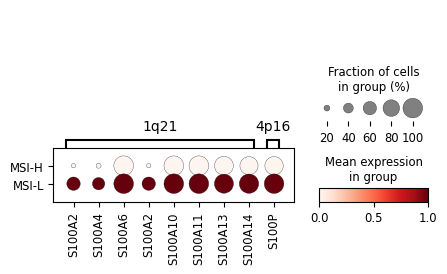

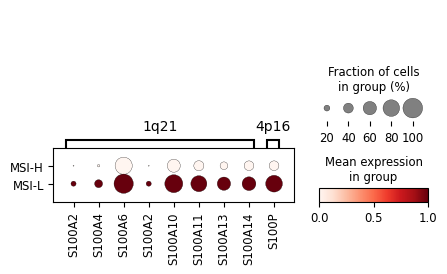

In [484]:
sc.pl.dotplot(adata_epi_joanito_tumor_1, var_names=dict_region_to_S100_gene, groupby='MSI_class', standard_scale='var',)
sc.pl.dotplot(adata_epi_chen_tumor_1, var_names=dict_region_to_S100_gene, groupby='MSI_class', standard_scale='var',)

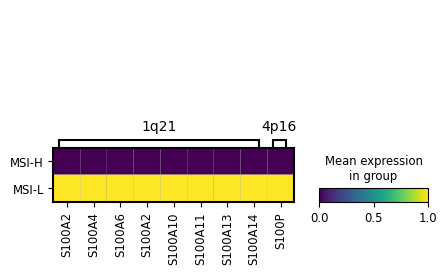

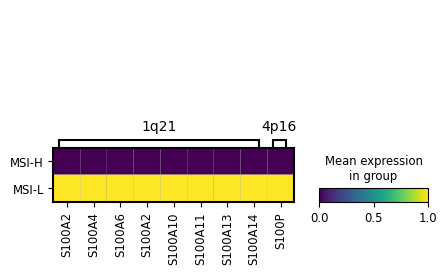

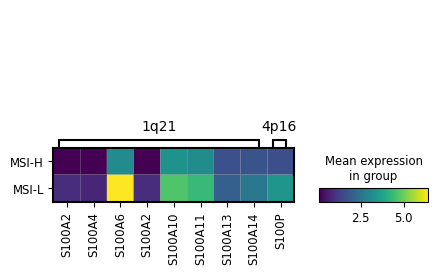

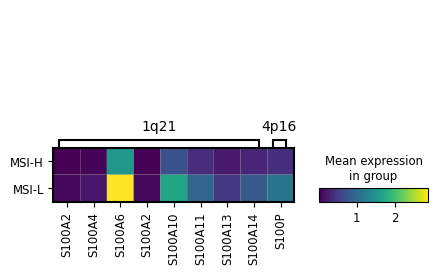

In [486]:
sc.pl.matrixplot(adata_epi_joanito_tumor_1, var_names=dict_region_to_S100_gene, groupby='MSI_class', standard_scale='var',)
sc.pl.matrixplot(adata_epi_chen_tumor_1, var_names=dict_region_to_S100_gene, groupby='MSI_class', standard_scale='var',)

sc.pl.matrixplot(adata_epi_joanito_tumor_1, var_names=dict_region_to_S100_gene, groupby='MSI_class', )
sc.pl.matrixplot(adata_epi_chen_tumor_1, var_names=dict_region_to_S100_gene, groupby='MSI_class', )

In [493]:
chen_patient_order_by_MSI_intensity
chen_patient_order_by_MSI_intensity_2 = ['P18', 'P17','P23', 'P21', 'P04']

In [492]:
set(adata_epi_chen_tumor.obs[(adata_epi_chen_tumor.obs['MSI_class']=='MSI-I')]['PatientID'])

{'P15', 'P19', 'P20', 'P22', 'P26'}

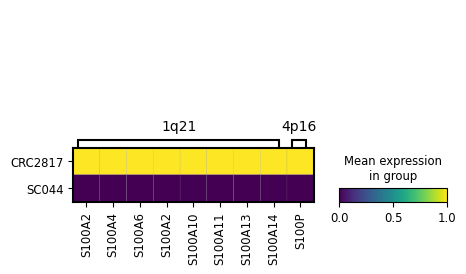

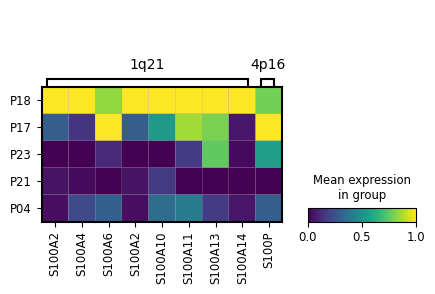

In [494]:
sc.pl.matrixplot(adata_epi_joanito_tumor_1, var_names=dict_region_to_S100_gene, groupby='PatientID', categories_order=['CRC2817', 'SC044'], standard_scale='var',)
sc.pl.matrixplot(adata_epi_chen_tumor_1, var_names=dict_region_to_S100_gene, groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity_2, standard_scale='var',)

In [ ]:
adata_epi_chen_tme = adata_epi_chen_tme[adata_epi_chen_tme.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity)]
adata_epi_joanito_tme = adata_epi_joanito_tme[adata_epi_joanito_tme.obs['PatientID'].isin(joanito_patient_order_by_MSI_intensity)]

In [504]:
adata_epi_chen_tme.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_chen_tme.obs['PatientID'] ]
adata_epi_joanito_tme.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_joanito_tme.obs['PatientID'] ]

/tmp/ipykernel_34693/3981464853.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_epi_chen_tme.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_chen_tme.obs['PatientID'] ]
/tmp/ipykernel_34693/3981464853.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_epi_joanito_tme.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_joanito_tme.obs['PatientID'] ]


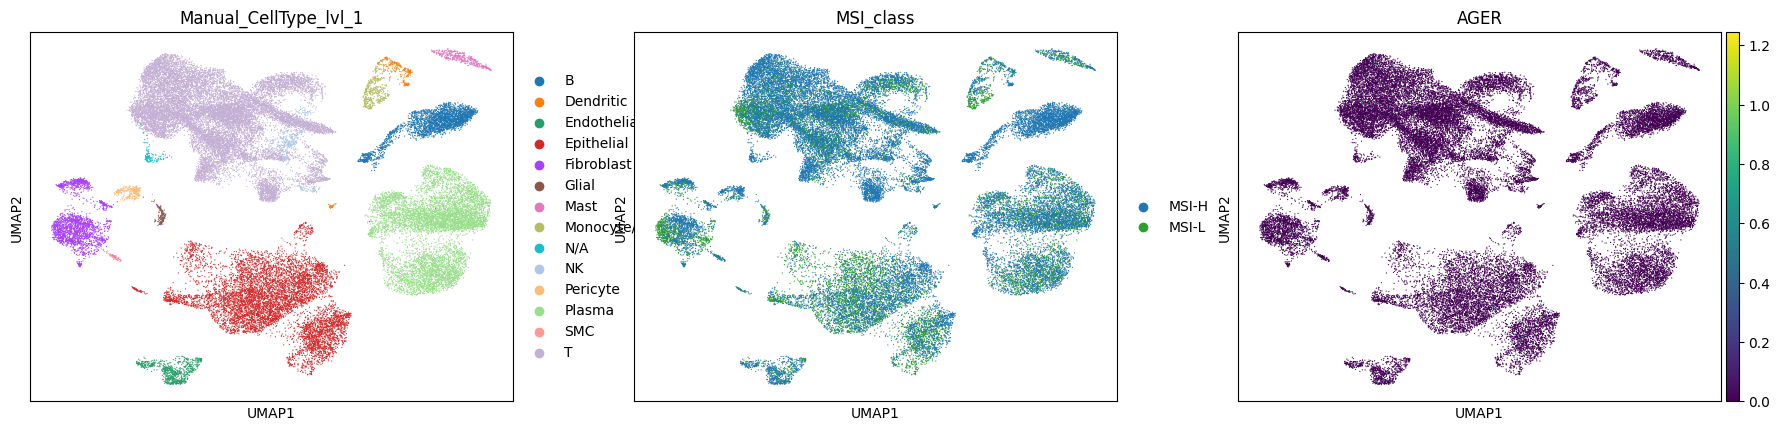

In [511]:
sc.pl.umap(adata_epi_chen_tme[adata_epi_chen_tme.obs['MSI_class']!='MSI-I'], 
           color=['Manual_CellType_lvl_1', 'MSI_class', 'AGER'])

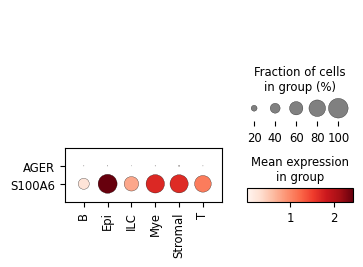

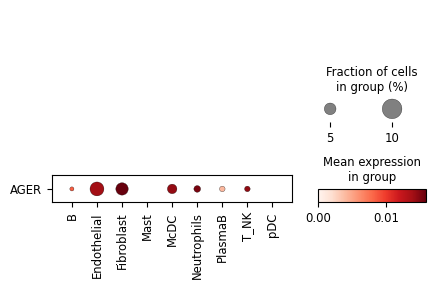

In [542]:
sc.pl.dotplot(adata_epi_chen_tme[adata_epi_chen_tme.obs['BiopsySite']=='Tumor'], groupby='Author_CellType_lvl_1', var_names=['AGER',], swap_axes=True,)
sc.pl.dotplot(adata_epi_joanito_tme[adata_epi_joanito_tme.obs['BiopsySite']=='Tumor'], groupby='Author_CellType_lvl_1', var_names=['AGER'], swap_axes=True,)

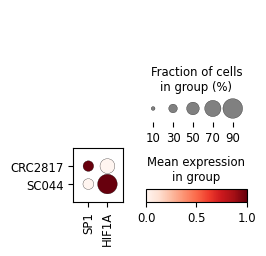

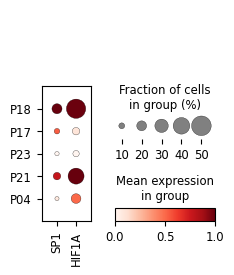

In [566]:
sc.pl.dotplot(adata_epi_joanito_tumor_1, var_names=['SP1', 'HIF1A'], groupby='PatientID', categories_order=['CRC2817', 'SC044'], standard_scale='var',)
sc.pl.dotplot(adata_epi_chen_tumor_1, var_names=['SP1', 'HIF1A'], groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity_2, standard_scale='var',)